# DeepForest: Análisis completo
Detección de árboles, análisis de índices de vegetación e interpretación RGB.

In [2]:
# 1. Carga de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Verificación de existencia de módulos antes de cargar el modelo DeepForest
try:
    from deepforest import main
    from deepforest import get_data
    from deepforest.visualize import plot_results
except ImportError as e:
    print(f"Error al importar DeepForest: {e}")


c:\Users\mige1\miniconda3\envs\deepforest_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mige1\miniconda3\envs\deepforest_env\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# 2. Inicialización del modelo
model = main.deepforest()

try:
    model.load_model(model_name="weecology/deepforest-tree", revision="main")
    print("Modelo cargado correctamente")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")


Reading config file: c:\Users\mige1\miniconda3\envs\deepforest_env\lib\site-packages\deepforest\data\deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: c:\Users\mige1\miniconda3\envs\deepforest_env\lib\site-packages\deepforest\data\deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Modelo cargado correctamente


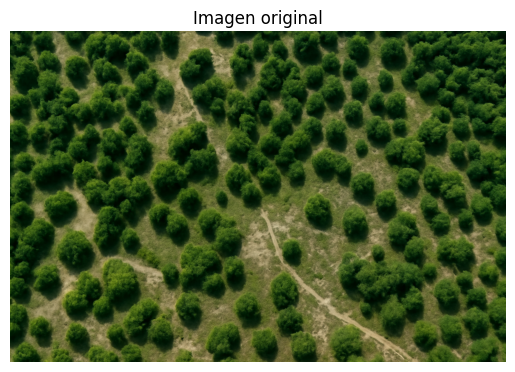

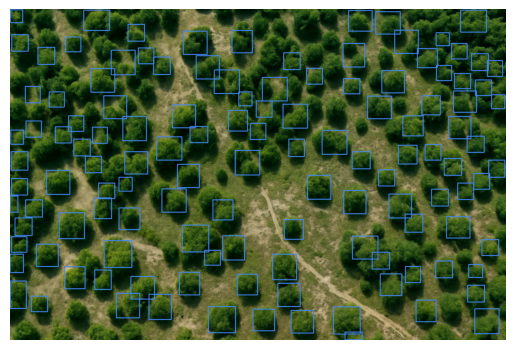

Número de árboles detectados: 124


In [4]:
# 3. Carga de imagen y predicción
sample_image_path = "g.png"  # Ruta de la imagen de ejemplo
img_in = Image.open(sample_image_path)

# Mostrar la imagen cargada
plt.imshow(img_in)
plt.title("Imagen original")
plt.axis('off')
plt.show()

# Convertir la imagen a un array y realizar la predicción
img_array = np.array(img_in)
img_out = model.predict_image(path=sample_image_path)

# Mostrar resultados visualmente
plot_results(img_out)
plt.show()

# Mostrar cuántos árboles han sido detectados
num_trees = len(img_out)
print(f"Número de árboles detectados: {num_trees}")


In [5]:
# 4. Cálculo de áreas e ID
img_out["id_arbol"] = range(1, len(img_out) + 1)  # Asignación de un ID único a cada árbol
img_out["area_px"] = (img_out["xmax"] - img_out["xmin"]) * (img_out["ymax"] - img_out["ymin"])

# Mostrar las primeras 20 filas
print(img_out[["id_arbol", "area_px"]].head(20))



    id_arbol  area_px
0          1   2756.0
1          2   6804.0
2          3   4489.0
3          4   3906.0
4          5   2500.0
5          6   7138.0
6          7   5328.0
7          8   1272.0
8          9   1763.0
9         10   3658.0
10        11   2350.0
11        12   4284.0
12        13   5475.0
13        14   3060.0
14        15   2401.0
15        16   2350.0
16        17   3080.0
17        18   2652.0
18        19   5328.0
19        20   3364.0


In [6]:
# 5. Cálculo de índices de vegetación (ExG y VARI)
img_float = img_array.astype(float)

# Definir las bandas R, G, y B
R = img_float[:, :, 0]
G = img_float[:, :, 1]
B = img_float[:, :, 2]

# Calcular el ExG (Excess Green)
ExG = 2 * G - R - B

# Calcular el VARI (Visible Atmospherically Resistant Index)
epsilon = 1e-6
VARI = (G - R) / (G + R - B + epsilon)

# Función para calcular los valores promedio de ExG y VARI dentro del área delimitada de cada árbol
def calculate_means(row, ExG, VARI):
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    ExG_crop = ExG[ymin:ymax, xmin:xmax]
    VARI_crop = VARI[ymin:ymax, xmin:xmax]
    
    # Calcular y retornar los valores promedio de ExG y VARI
    return np.mean(ExG_crop), np.mean(VARI_crop)

# Usar apply() para aplicar la función a cada fila del DataFrame
img_out["ExG_mean"], img_out["VARI_mean"] = zip(*img_out.apply(calculate_means, axis=1, ExG=ExG, VARI=VARI))



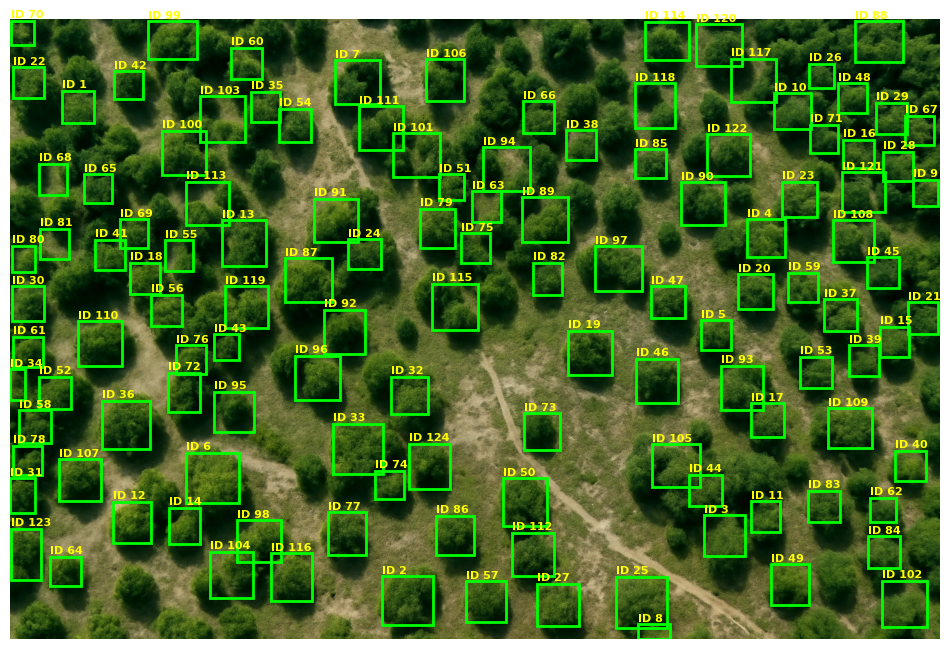

In [7]:
# 6. Mostrar cajas e IDs
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img_array)
for _, row in img_out.iterrows():
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor="lime", facecolor="none", linewidth=2)
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, f'ID {int(row["id_arbol"])}', color='yellow', fontsize=8, weight='bold')
plt.axis('off')
plt.show()

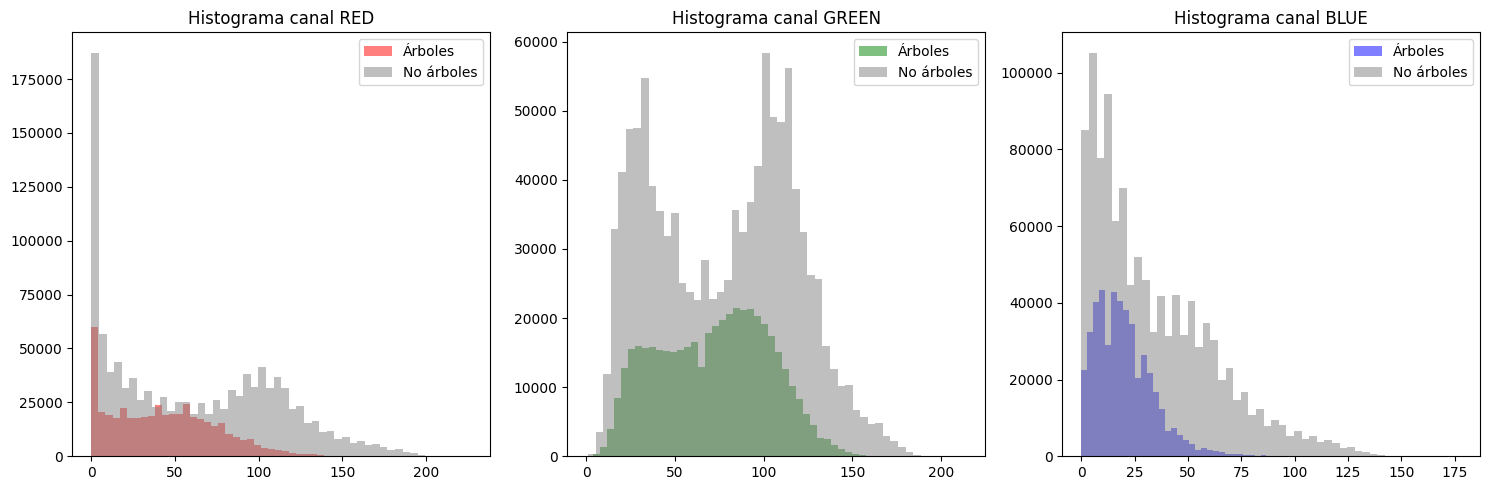

In [8]:
# 7. Histogramas RGB
mask = np.zeros((img_array.shape[0], img_array.shape[1]), dtype=bool)
for _, row in img_out.iterrows():
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    mask[ymin:ymax, xmin:xmax] = True
pixels_arbol = img_array[mask]
pixels_no_arbol = img_array[~mask]
plt.figure(figsize=(15, 5))
for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.hist(pixels_arbol[:, i], bins=50, alpha=0.5, label="Árboles", color=color)
    plt.hist(pixels_no_arbol[:, i], bins=50, alpha=0.5, label="No árboles", color='gray')
    plt.title(f'Histograma canal {color.upper()}')
    plt.legend()
plt.tight_layout()
plt.show()

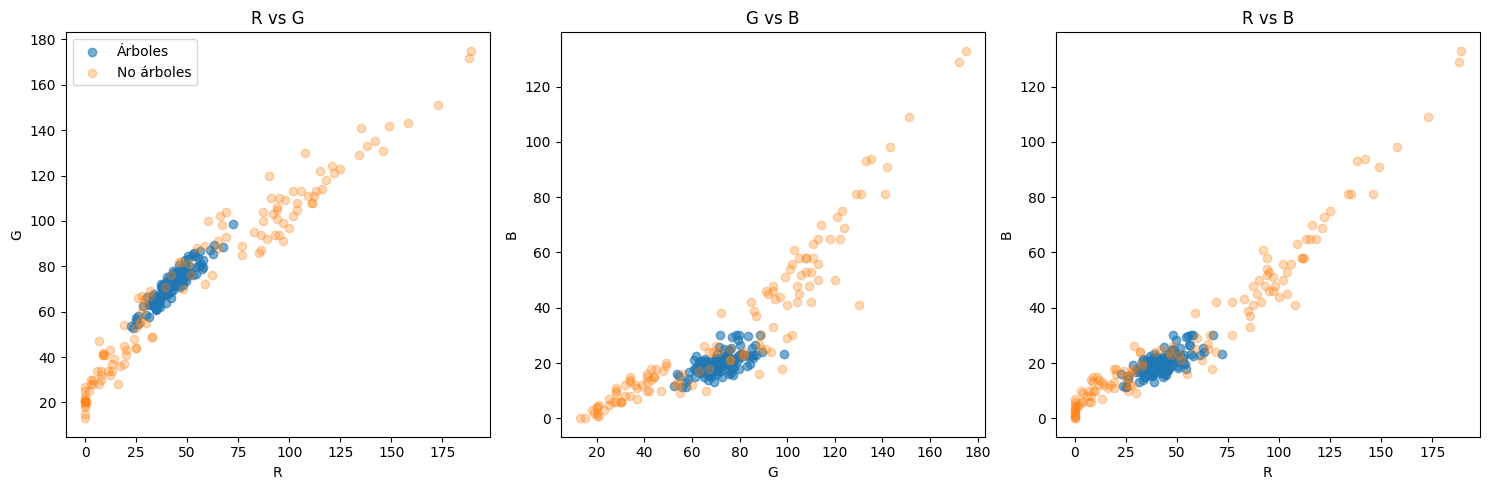

In [9]:
# 8. Diagramas de dispersión RGB
img_out["R_mean"] = img_out.apply(lambda row: np.mean(img_array[int(row.ymin):int(row.ymax), int(row.xmin):int(row.xmax), 0]), axis=1)
img_out["G_mean"] = img_out.apply(lambda row: np.mean(img_array[int(row.ymin):int(row.ymax), int(row.xmin):int(row.xmax), 1]), axis=1)
img_out["B_mean"] = img_out.apply(lambda row: np.mean(img_array[int(row.ymin):int(row.ymax), int(row.xmin):int(row.xmax), 2]), axis=1)
samples_out = pixels_no_arbol[np.random.choice(len(pixels_no_arbol), len(img_out), replace=False)]
R_no, G_no, B_no = samples_out[:,0], samples_out[:,1], samples_out[:,2]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(img_out["R_mean"], img_out["G_mean"], label="Árboles", alpha=0.6)
plt.scatter(R_no, G_no, label="No árboles", alpha=0.3)
plt.title("R vs G"); plt.xlabel("R"); plt.ylabel("G"); plt.legend()
plt.subplot(1, 3, 2)
plt.scatter(img_out["G_mean"], img_out["B_mean"], label="Árboles", alpha=0.6)
plt.scatter(G_no, B_no, label="No árboles", alpha=0.3)
plt.title("G vs B"); plt.xlabel("G"); plt.ylabel("B")
plt.subplot(1, 3, 3)
plt.scatter(img_out["R_mean"], img_out["B_mean"], label="Árboles", alpha=0.6)
plt.scatter(R_no, B_no, label="No árboles", alpha=0.3)
plt.title("R vs B"); plt.xlabel("R"); plt.ylabel("B")
plt.tight_layout()
plt.show()

In [10]:
# 9. Guardar CSV
img_out.to_csv("datos_arboles.csv", index=False)
print("Archivo 'datos_arboles.csv' guardado.")


Archivo 'datos_arboles.csv' guardado.
